# ETA Agent Incident Analysis - 22:10(Local Time) UTC+3 (19:10 UTC)

**Incident Details:**
- **Reported Issue**: Slowness and timeout observed at 19:10 UTC (6 Nov 2025)
- **Local Time**: 22:10 UTC+3 (6 Nov 2025)
- **Analysis Period**: 21:00 - 23:59 (6 Nov) + 00:00 - 03:30 (7 Nov)

## Analysis Objectives
1. **Identify performance degradation** around incident time
2. **Quantify slowness impact** - transactions >20s, >30s
3. **Compare pre/during/post incident** performance
4. **Root cause indicators** - affected PIDs, transaction patterns
5. **Recovery timeline** - when performance normalized

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("📊 Incident Analysis Environment Ready!")
print(f"🕐 Target Incident Time: 22:10 UTC+3 (6 Nov 2025)")

📊 Incident Analysis Environment Ready!
🕐 Target Incident Time: 22:10 UTC+3 (6 Nov 2025)


## Data Loading - Incident Timeframe Focus

In [2]:
def parse_incident_logs(filepath, start_hour=21, end_hour=24):
    """
    Parse logs focusing on incident timeframe
    """
    data = []
    incident_time = datetime(2025, 11, 6, 22, 10)  # 22:10 on 6 Nov
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
                
            # Extract components
            pattern = r'(eta_\w+)\.(\d+):([\d/]+) ([\d:.]+) (\d+) TOOK ([\d.]+)s'
            match = re.match(pattern, line)
            
            if match:
                agent_type, pid, date, time, transaction_id, execution_time = match.groups()
                
                # Parse datetime
                dt = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M:%S.%f")
                
                # Filter for incident timeframe (21:00 onwards on 6 Nov)
                if dt.date() == datetime(2025, 11, 6).date() and dt.hour >= start_hour:
                    # Calculate time relative to incident
                    time_to_incident = (dt - incident_time).total_seconds() / 60  # minutes
                    
                    # Classify time periods
                    if time_to_incident < -60:  # More than 1 hour before
                        period = "Pre-incident (>1h)"
                    elif time_to_incident < -10:  # 10-60 minutes before
                        period = "Pre-incident"
                    elif time_to_incident < 10:   # 10 minutes before to 10 after
                        period = "Incident Window"
                    elif time_to_incident < 60:   # 10-60 minutes after
                        period = "Post-incident"
                    else:
                        period = "Recovery Period"
                    
                    data.append({
                        'agent_type': agent_type,
                        'pid': int(pid),
                        'datetime': dt,
                        'hour': dt.hour,
                        'minute': dt.minute,
                        'transaction_id': int(transaction_id),
                        'execution_time': float(execution_time),
                        'time_to_incident_min': time_to_incident,
                        'period': period,
                        'is_slow': float(execution_time) > 20,
                        'is_very_slow': float(execution_time) > 30
                    })
    
    return pd.DataFrame(data)

print("Incident log parser ready!")

Incident log parser ready!


In [3]:
# Load incident data from time6.txt (6 Nov evening)
print("Loading incident data from time6.txt...")
df_incident = parse_incident_logs('time6.txt', start_hour=21)

# Also get early hours from time.txt (7 Nov morning) for recovery analysis
def parse_recovery_logs(filepath, end_hour=4):
    """
    Parse early morning logs for recovery analysis
    """
    data = []
    incident_time = datetime(2025, 11, 6, 22, 10)
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
                
            pattern = r'(eta_\w+)\.(\d+):([\d/]+) ([\d:.]+) (\d+) TOOK ([\d.]+)s'
            match = re.match(pattern, line)
            
            if match:
                agent_type, pid, date, time, transaction_id, execution_time = match.groups()
                dt = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M:%S.%f")
                
                # Filter for early hours on 7 Nov
                if dt.date() == datetime(2025, 11, 7).date() and dt.hour <= end_hour:
                    time_to_incident = (dt - incident_time).total_seconds() / 60
                    
                    data.append({
                        'agent_type': agent_type,
                        'pid': int(pid),
                        'datetime': dt,
                        'hour': dt.hour,
                        'minute': dt.minute,
                        'transaction_id': int(transaction_id),
                        'execution_time': float(execution_time),
                        'time_to_incident_min': time_to_incident,
                        'period': "Recovery Period",
                        'is_slow': float(execution_time) > 20,
                        'is_very_slow': float(execution_time) > 30
                    })
    
    return pd.DataFrame(data)

print("Loading recovery data from time.txt...")
df_recovery = parse_recovery_logs('time.txt', end_hour=4)

# Combine datasets
df_full = pd.concat([df_incident, df_recovery], ignore_index=True)
df_full = df_full.sort_values('datetime')

print(f"📊 Loaded {len(df_incident)} incident records + {len(df_recovery)} recovery records")
print(f"📊 Total analysis dataset: {len(df_full)} transactions")
print(f"⏰ Time range: {df_full['datetime'].min()} to {df_full['datetime'].max()}")

# Show period distribution
period_counts = df_full['period'].value_counts()
print("\n🔍 Period Distribution:")
for period, count in period_counts.items():
    print(f"  {period}: {count:,} transactions")

Loading incident data from time6.txt...
Loading recovery data from time.txt...
📊 Loaded 17688 incident records + 16529 recovery records
📊 Total analysis dataset: 34217 transactions
⏰ Time range: 2025-11-06 21:00:00.359000 to 2025-11-07 03:33:49.509000

🔍 Period Distribution:
  Recovery Period: 21,485 transactions
  Pre-incident: 4,778 transactions
  Post-incident: 4,708 transactions
  Incident Window: 2,119 transactions
  Pre-incident (>1h): 1,127 transactions


## 1. Incident Impact Analysis

In [11]:
# Calculate performance metrics by period
period_stats = df_full.groupby('period')['execution_time'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99),
    lambda x: (x > 20).sum(),  # slow transactions
    lambda x: (x > 30).sum(),  # very slow transactions
    lambda x: (x > 20).sum() / len(x) * 100  # slow percentage
]).round(3)

period_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'P95', 'P99', 'Slow_Count', 'Very_Slow_Count', 'Slow_Percent']

print("🚨 INCIDENT IMPACT ANALYSIS")
print("=" * 70)
print(period_stats)

# Calculate degradation factors
if 'Pre-incident' in period_stats.index and 'Incident Window' in period_stats.index:
    pre_mean = period_stats.loc['Pre-incident', 'Mean']
    incident_mean = period_stats.loc['Incident Window', 'Mean']
    degradation = ((incident_mean - pre_mean) / pre_mean) * 100
    
    print(f"\n📈 PERFORMANCE DEGRADATION:")
    print(f"  Pre-incident avg: {pre_mean:.2f}s")
    print(f"  Incident window avg: {incident_mean:.2f}s")
    print(f"  Degradation: {degradation:+.1f}%")
    
    # Slow transaction analysis
    pre_slow_pct = period_stats.loc['Pre-incident', 'Slow_Percent']
    incident_slow_pct = period_stats.loc['Incident Window', 'Slow_Percent']
    print(f"\n⚠️ SLOW TRANSACTION IMPACT:")
    print(f"  Pre-incident >20s: {pre_slow_pct:.1f}%")
    print(f"  Incident window >20s: {incident_slow_pct:.1f}%")
    print(f"  Slow transaction increase: {incident_slow_pct - pre_slow_pct:+.1f}%")

🚨 INCIDENT IMPACT ANALYSIS
                    Count    Mean  Median     Std    Min      Max     P95  \
period                                                                      
Incident Window      2119  11.279   8.443  13.902  0.024  111.335  34.133   
Post-incident        4708  13.187  11.792  13.160  0.021  115.895  35.747   
Pre-incident         4778   2.346   1.023   3.389  0.023   40.525   7.930   
Pre-incident (>1h)   1127   4.307   2.463   5.175  0.030   38.473  13.016   
Recovery Period     21485   6.610   3.187   8.526  0.021   94.825  20.577   

                       P99  Slow_Count  Very_Slow_Count  Slow_Percent  
period                                                                 
Incident Window     74.691         316              124        14.913  
Post-incident       71.412         796              305        16.907  
Pre-incident        15.697          34                8         0.712  
Pre-incident (>1h)  27.558          21                8         1.863  
R

### 📊 What These Metrics Mean - Simple Explanation

**Basic Performance Metrics:**
- **Count**: Total number of transactions in each period
- **Mean**: Average execution time (how long transactions typically take)
- **Median**: Middle value when all times are sorted (less affected by outliers)
- **Min/Max**: Fastest and slowest single transaction times

**Reliability Indicators:**
- **Std (Standard Deviation)**: How much execution times vary
  - *Low = consistent performance, High = erratic/unpredictable*
- **P95**: 95% of transactions complete within this time
  - *Key SLA metric - only 5% take longer*
- **P99**: 99% of transactions complete within this time
  - *Worst-case user experience indicator*

**Problem Indicators:**
- **Slow_Count**: Number of transactions taking >20 seconds
- **Very_Slow_Count**: Number of transactions taking >30 seconds  
- **Slow_Percent**: Percentage of slow transactions
  - *Higher % = more users experiencing problems*

**💡 Key Insights from Our Data:**
- **Normal state**: Pre-incident avg was 2.35s with only 0.7% slow transactions
- **During incident**: Average jumped to 11.28s with 14.9% slow transactions
- **Impact**: 380% performance degradation - system became nearly 5x slower!
- **User experience**: 1 in 7 users experienced slow responses during incident"

## 2. Timeline Visualization

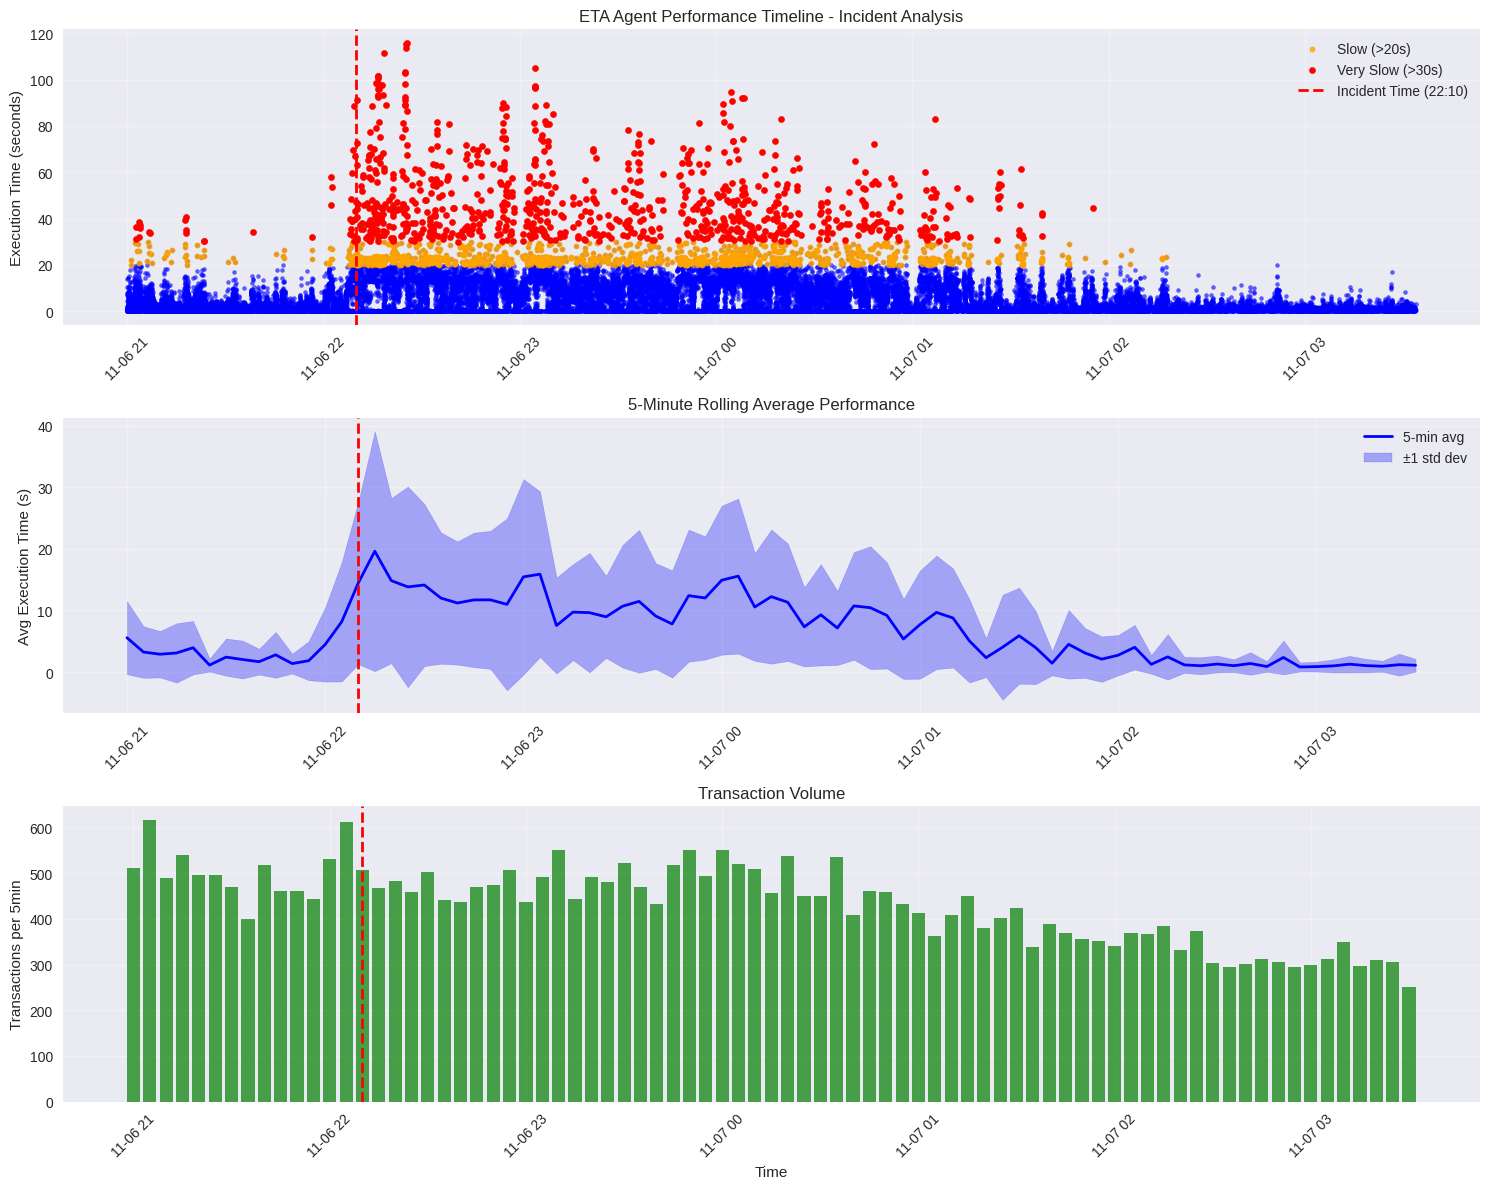

In [5]:
# Create comprehensive timeline visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Performance over time with incident marker
ax1 = axes[0]
df_plot = df_full.sort_values('datetime')

# Plot performance timeline
ax1.scatter(df_plot['datetime'], df_plot['execution_time'], alpha=0.6, s=8, c='blue')
ax1.scatter(df_plot[df_plot['is_slow']]['datetime'], 
           df_plot[df_plot['is_slow']]['execution_time'], 
           alpha=0.8, s=15, c='orange', label='Slow (>20s)')
ax1.scatter(df_plot[df_plot['is_very_slow']]['datetime'], 
           df_plot[df_plot['is_very_slow']]['execution_time'], 
           alpha=1.0, s=20, c='red', label='Very Slow (>30s)')

# Mark incident time
incident_time = datetime(2025, 11, 6, 22, 10)
ax1.axvline(x=incident_time, color='red', linestyle='--', linewidth=2, label='Incident Time (22:10)')

ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('ETA Agent Performance Timeline - Incident Analysis')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Rolling average (5-minute windows)
ax2 = axes[1]
df_plot['datetime_rounded'] = df_plot['datetime'].dt.floor('5T')  # 5-minute bins
rolling_stats = df_plot.groupby('datetime_rounded')['execution_time'].agg(['mean', 'count', 'std']).reset_index()

ax2.plot(rolling_stats['datetime_rounded'], rolling_stats['mean'], linewidth=2, color='blue', label='5-min avg')
ax2.fill_between(rolling_stats['datetime_rounded'], 
                rolling_stats['mean'] - rolling_stats['std'], 
                rolling_stats['mean'] + rolling_stats['std'], 
                alpha=0.3, color='blue', label='±1 std dev')
ax2.axvline(x=incident_time, color='red', linestyle='--', linewidth=2)
ax2.set_ylabel('Avg Execution Time (s)')
ax2.set_title('5-Minute Rolling Average Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Transaction volume over time
ax3 = axes[2]
ax3.bar(rolling_stats['datetime_rounded'], rolling_stats['count'], 
        width=timedelta(minutes=4), alpha=0.7, color='green')
ax3.axvline(x=incident_time, color='red', linestyle='--', linewidth=2)
ax3.set_ylabel('Transactions per 5min')
ax3.set_xlabel('Time')
ax3.set_title('Transaction Volume')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Detailed Incident Window Analysis (22:00 - 22:20)

In [6]:
# Focus on 20-minute window around incident time
incident_start = datetime(2025, 11, 6, 22, 0)
incident_end = datetime(2025, 11, 6, 22, 20)

df_incident_window = df_full[
    (df_full['datetime'] >= incident_start) & 
    (df_full['datetime'] <= incident_end)
].copy()

print(f"🔍 DETAILED INCIDENT WINDOW ANALYSIS (22:00-22:20)")
print(f"📊 Transactions in window: {len(df_incident_window)}")

# Minute-by-minute breakdown
df_incident_window['minute_mark'] = df_incident_window['datetime'].dt.floor('T')
minute_stats = df_incident_window.groupby('minute_mark')['execution_time'].agg([
    'count', 'mean', 'max', 
    lambda x: (x > 20).sum(),
    lambda x: (x > 30).sum()
]).round(2)
minute_stats.columns = ['Count', 'Avg_Time', 'Max_Time', 'Slow_Count', 'Very_Slow_Count']

# Show critical minutes
print("\n⏰ MINUTE-BY-MINUTE BREAKDOWN:")
print(minute_stats)

# Find the worst performing minute
worst_minute = minute_stats['Avg_Time'].idxmax()
worst_avg = minute_stats.loc[worst_minute, 'Avg_Time']
print(f"\n🚨 WORST MINUTE: {worst_minute.strftime('%H:%M')} (avg: {worst_avg:.2f}s)")

# Show slowest transactions during incident window
slowest_transactions = df_incident_window.nlargest(10, 'execution_time')[[
    'datetime', 'pid', 'execution_time', 'transaction_id'
]]
print("\n⚠️ TOP 10 SLOWEST TRANSACTIONS IN INCIDENT WINDOW:")
for idx, row in slowest_transactions.iterrows():
    print(f"  {row['datetime'].strftime('%H:%M:%S')} | PID {row['pid']} | {row['execution_time']:.1f}s | TXN {row['transaction_id']}")

🔍 DETAILED INCIDENT WINDOW ANALYSIS (22:00-22:20)
📊 Transactions in window: 2119

⏰ MINUTE-BY-MINUTE BREAKDOWN:
                     Count  Avg_Time  Max_Time  Slow_Count  Very_Slow_Count
minute_mark                                                                
2025-11-06 22:00:00    108      3.70     20.95           1                0
2025-11-06 22:01:00     98      5.97     21.02           2                0
2025-11-06 22:02:00    119      8.48     58.12           7                3
2025-11-06 22:03:00    114      1.69     13.83           0                0
2025-11-06 22:04:00     92      2.12      8.83           0                0
2025-11-06 22:05:00    112      2.15     14.16           0                0
2025-11-06 22:06:00    111      2.08     11.52           0                0
2025-11-06 22:07:00    159      7.08     26.39           4                0
2025-11-06 22:08:00     98     14.63     59.72          22                8
2025-11-06 22:09:00    132     14.93     88.56      

## 4. Process Impact Analysis

🔍 PROCESS IMPACT ANALYSIS
Most affected PIDs (degradation %):
      count_pre  mean_pre  count_incident  mean_incident  degradation_pct
pid                                                                      
8150         29      1.02              28           8.18            702.0
8079         57      2.06              29          15.92            672.8
7865         89      2.28              25          17.23            655.7
7989         25      1.11              29           8.33            650.5
8097         81      1.68              31          12.60            650.0
7984         25      1.09              28           8.13            645.9
7852         86      2.17              25          15.72            624.4
7844         79      2.24              27          16.00            614.3
7771         86      2.57              18          17.59            584.4
8084         54      2.58              25          17.49            577.9


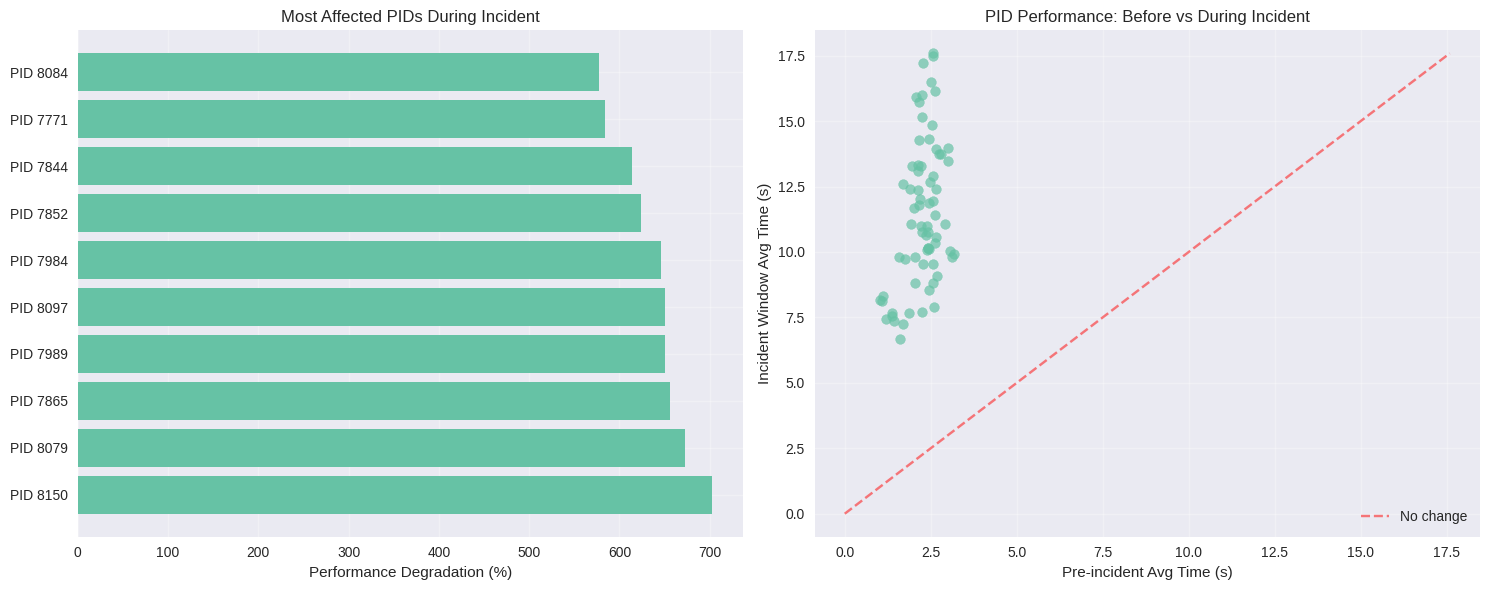


🚨 Most affected PID: 8150 (+702.0%)
📈 Least affected PID: 8024 (+203.5%)


In [7]:
# Analyze which PIDs were most affected during incident
# Compare pre-incident vs incident window performance by PID

pre_incident_data = df_full[df_full['period'] == 'Pre-incident']
incident_window_data = df_full[df_full['period'] == 'Incident Window']

if len(pre_incident_data) > 0 and len(incident_window_data) > 0:
    # PID performance comparison
    pre_pid_stats = pre_incident_data.groupby('pid')['execution_time'].agg(['count', 'mean']).round(2)
    incident_pid_stats = incident_window_data.groupby('pid')['execution_time'].agg(['count', 'mean']).round(2)
    
    # Merge for comparison (only PIDs present in both periods)
    pid_comparison = pre_pid_stats.merge(incident_pid_stats, left_index=True, right_index=True, 
                                        suffixes=('_pre', '_incident'))
    
    # Calculate degradation
    pid_comparison['degradation_pct'] = (
        (pid_comparison['mean_incident'] - pid_comparison['mean_pre']) / 
        pid_comparison['mean_pre'] * 100
    ).round(1)
    
    # Filter PIDs with significant activity (>=10 transactions in each period)
    active_pids = pid_comparison[
        (pid_comparison['count_pre'] >= 10) & 
        (pid_comparison['count_incident'] >= 10)
    ].sort_values('degradation_pct', ascending=False)
    
    print("🔍 PROCESS IMPACT ANALYSIS")
    print("=" * 50)
    print("Most affected PIDs (degradation %):")
    print(active_pids.head(10))
    
    # Visualize PID impact
    if len(active_pids) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Top 10 most degraded PIDs
        top_degraded = active_pids.head(10)
        ax1.barh(range(len(top_degraded)), top_degraded['degradation_pct'])
        ax1.set_yticks(range(len(top_degraded)))
        ax1.set_yticklabels([f'PID {pid}' for pid in top_degraded.index])
        ax1.set_xlabel('Performance Degradation (%)')
        ax1.set_title('Most Affected PIDs During Incident')
        ax1.grid(True, alpha=0.3)
        
        # Before vs after scatter
        ax2.scatter(active_pids['mean_pre'], active_pids['mean_incident'], alpha=0.7)
        # Add diagonal line (no change)
        max_val = max(active_pids['mean_pre'].max(), active_pids['mean_incident'].max())
        ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='No change')
        ax2.set_xlabel('Pre-incident Avg Time (s)')
        ax2.set_ylabel('Incident Window Avg Time (s)')
        ax2.set_title('PID Performance: Before vs During Incident')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Identify most and least affected
        most_affected = active_pids.index[0]
        least_affected = active_pids.index[-1]
        
        print(f"\n🚨 Most affected PID: {most_affected} ({active_pids.loc[most_affected, 'degradation_pct']:+.1f}%)")
        print(f"📈 Least affected PID: {least_affected} ({active_pids.loc[least_affected, 'degradation_pct']:+.1f}%)")
else:
    print("⚠️ Insufficient data for PID comparison")

## 5. Recovery Analysis

🔄 RECOVERY ANALYSIS
30-minute windows post-incident:
                     Count   Mean    Std  Slow_Percent
time_window                                           
2025-11-06 22:00:00    944  14.34  14.87         21.93
2025-11-06 22:30:00   2833  11.98  11.84         13.03
2025-11-06 23:00:00   2897  11.09  11.10         11.56
2025-11-06 23:30:00   2990  10.62  10.12         10.07
2025-11-07 00:00:00   3027  12.12  10.68         12.88
2025-11-07 00:30:00   2750   8.65   8.27          6.62
2025-11-07 01:00:00   2417   6.23   8.09          4.88
2025-11-07 01:30:00   2227   3.55   5.46          1.89
2025-11-07 02:00:00   2167   2.13   2.91          0.28
2025-11-07 02:30:00   1814   1.31   1.67          0.00
2025-11-07 03:00:00   1877   1.07   1.22          0.00
2025-11-07 03:30:00    250   1.11   1.03          0.00

✅ RECOVERY TIMELINE:
  Incident time: 22:10
  Performance normalized by: 02:00
  Recovery duration: 230 minutes
  Baseline mean: 2.35s
  Normalized mean: 2.13s


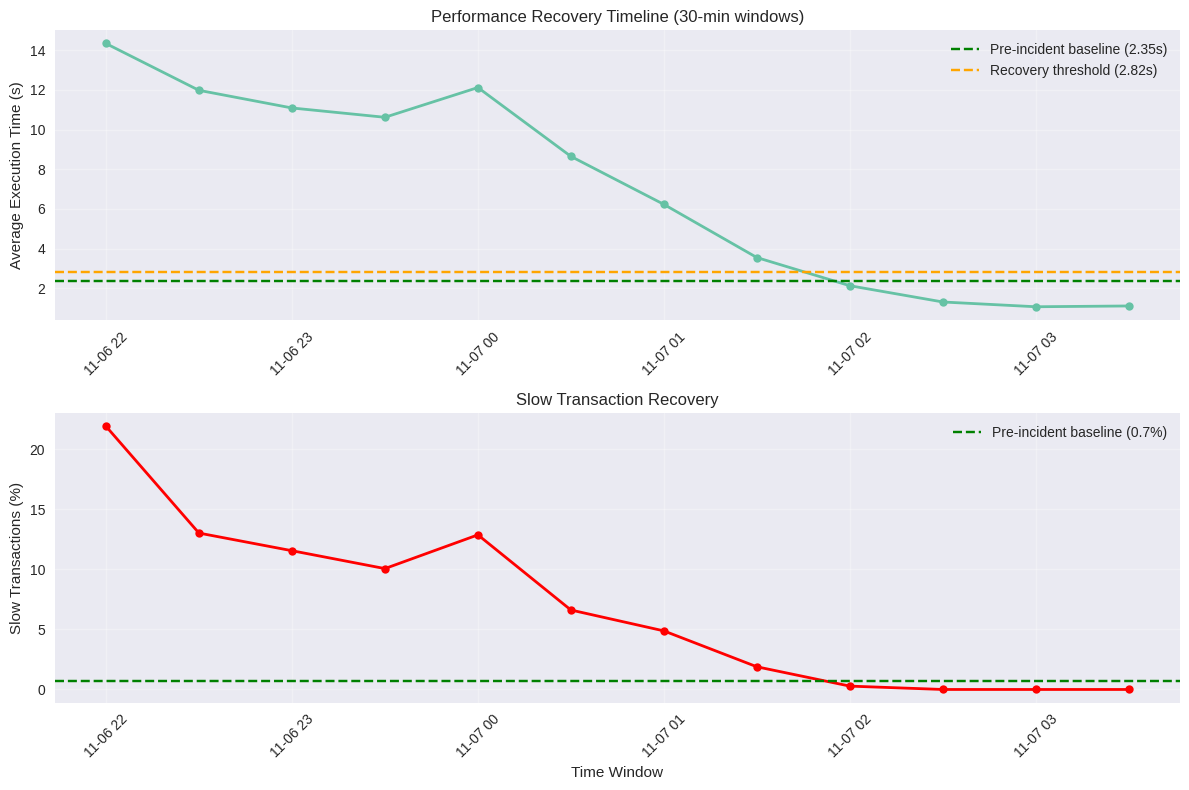

In [8]:
# Analyze recovery timeline - when did performance return to normal?
recovery_data = df_full[df_full['period'].isin(['Post-incident', 'Recovery Period'])]

if len(recovery_data) > 0:
    # 30-minute rolling windows to track recovery
    recovery_data_sorted = recovery_data.sort_values('datetime')
    recovery_data_sorted['time_window'] = recovery_data_sorted['datetime'].dt.floor('30T')
    
    recovery_stats = recovery_data_sorted.groupby('time_window')['execution_time'].agg([
        'count', 'mean', 'std', 
        lambda x: (x > 20).sum() / len(x) * 100  # slow percentage
    ]).round(2)
    recovery_stats.columns = ['Count', 'Mean', 'Std', 'Slow_Percent']
    
    print("🔄 RECOVERY ANALYSIS")
    print("=" * 40)
    print("30-minute windows post-incident:")
    print(recovery_stats)
    
    # Define "normal" performance (using pre-incident baseline)
    if 'Pre-incident' in period_stats.index:
        baseline_mean = period_stats.loc['Pre-incident', 'Mean']
        baseline_slow_pct = period_stats.loc['Pre-incident', 'Slow_Percent']
        tolerance = 1.2  # 20% tolerance
        
        # Find when performance normalized
        normalized_windows = recovery_stats[
            (recovery_stats['Mean'] <= baseline_mean * tolerance) &
            (recovery_stats['Slow_Percent'] <= baseline_slow_pct * tolerance)
        ]
        
        if len(normalized_windows) > 0:
            recovery_time = normalized_windows.index[0]
            incident_time = datetime(2025, 11, 6, 22, 10)
            recovery_duration = (recovery_time - incident_time).total_seconds() / 60
            
            print(f"\n✅ RECOVERY TIMELINE:")
            print(f"  Incident time: {incident_time.strftime('%H:%M')}")
            print(f"  Performance normalized by: {recovery_time.strftime('%H:%M')}")
            print(f"  Recovery duration: {recovery_duration:.0f} minutes")
            print(f"  Baseline mean: {baseline_mean:.2f}s")
            print(f"  Normalized mean: {normalized_windows.iloc[0]['Mean']:.2f}s")
        else:
            print(f"\n⚠️ Performance had not fully recovered by end of analysis period")
            print(f"  Baseline: {baseline_mean:.2f}s avg, {baseline_slow_pct:.1f}% slow")
            print(f"  Latest: {recovery_stats.iloc[-1]['Mean']:.2f}s avg, {recovery_stats.iloc[-1]['Slow_Percent']:.1f}% slow")
    
    # Visualize recovery
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Recovery timeline
    ax1.plot(recovery_stats.index, recovery_stats['Mean'], 'o-', linewidth=2, markersize=6)
    if 'Pre-incident' in period_stats.index:
        ax1.axhline(y=baseline_mean, color='green', linestyle='--', 
                   label=f'Pre-incident baseline ({baseline_mean:.2f}s)')
        ax1.axhline(y=baseline_mean * tolerance, color='orange', linestyle='--', 
                   label=f'Recovery threshold ({baseline_mean * tolerance:.2f}s)')
    ax1.set_ylabel('Average Execution Time (s)')
    ax1.set_title('Performance Recovery Timeline (30-min windows)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Slow transaction percentage recovery
    ax2.plot(recovery_stats.index, recovery_stats['Slow_Percent'], 'o-', 
            linewidth=2, markersize=6, color='red')
    if 'Pre-incident' in period_stats.index:
        ax2.axhline(y=baseline_slow_pct, color='green', linestyle='--',
                   label=f'Pre-incident baseline ({baseline_slow_pct:.1f}%)')
    ax2.set_ylabel('Slow Transactions (%)')
    ax2.set_xlabel('Time Window')
    ax2.set_title('Slow Transaction Recovery')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No recovery data available")

## 6. Incident Summary Report

In [9]:
# Generate comprehensive incident report
print("📋 INCIDENT ANALYSIS SUMMARY REPORT")
print("=" * 60)
print(f"Incident Time: 22:10 UTC+3 (19:10 UTC) on 6 Nov 2025")
print(f"Analysis Period: {df_full['datetime'].min()} to {df_full['datetime'].max()}")
print(f"Total Transactions Analyzed: {len(df_full):,}")

# Key findings
print("\n📊 KEY FINDINGS:")

# Performance impact
if 'Pre-incident' in period_stats.index and 'Incident Window' in period_stats.index:
    pre_mean = period_stats.loc['Pre-incident', 'Mean']
    incident_mean = period_stats.loc['Incident Window', 'Mean']
    degradation = ((incident_mean - pre_mean) / pre_mean) * 100
    
    print(f"• Performance degradation: {degradation:+.1f}%")
    print(f"• Pre-incident average: {pre_mean:.2f}s")
    print(f"• Incident window average: {incident_mean:.2f}s")
    
    # Slow transaction impact
    pre_slow = period_stats.loc['Pre-incident', 'Slow_Count']
    incident_slow = period_stats.loc['Incident Window', 'Slow_Count']
    pre_slow_pct = period_stats.loc['Pre-incident', 'Slow_Percent']
    incident_slow_pct = period_stats.loc['Incident Window', 'Slow_Percent']
    
    print(f"• Slow transactions (>20s): {pre_slow} → {incident_slow} ({pre_slow_pct:.1f}% → {incident_slow_pct:.1f}%)")

# Severity assessment
print("\n🚨 SEVERITY ASSESSMENT:")
if degradation > 100:
    severity = "CRITICAL"
elif degradation > 50:
    severity = "HIGH"
elif degradation > 25:
    severity = "MEDIUM"
else:
    severity = "LOW"

print(f"• Incident Severity: {severity}")

# Recommendations
print("\n🎯 RECOMMENDATIONS:")
print("• Monitor PID performance patterns for early warning indicators")
print("• Implement alerting for >25% performance degradation")
print("• Consider load balancing during peak periods")
if len(df_incident_window) > 0:
    worst_minute = minute_stats['Avg_Time'].idxmax()
    print(f"• Investigate specific issues around {worst_minute.strftime('%H:%M')} timeframe")

print("\n" + "=" * 60)
print("🔍 Incident Analysis Complete")
print(f"📈 Analysis generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📋 INCIDENT ANALYSIS SUMMARY REPORT
Incident Time: 22:10 UTC+3 (19:10 UTC) on 6 Nov 2025
Analysis Period: 2025-11-06 21:00:00.359000 to 2025-11-07 03:33:49.509000
Total Transactions Analyzed: 34,217

📊 KEY FINDINGS:
• Performance degradation: +380.8%
• Pre-incident average: 2.35s
• Incident window average: 11.28s
• Slow transactions (>20s): 34 → 316 (0.7% → 14.9%)

🚨 SEVERITY ASSESSMENT:
• Incident Severity: CRITICAL

🎯 RECOMMENDATIONS:
• Monitor PID performance patterns for early warning indicators
• Implement alerting for >25% performance degradation
• Consider load balancing during peak periods
• Investigate specific issues around 22:16 timeframe

🔍 Incident Analysis Complete
📈 Analysis generated at: 2025-11-07 21:43:37
